### CO2 - Summative (Data Loading to Conclusion)

In this case, we will use the **5-6PM** Dataset from our group's Roboflow workspace (https://universe.roboflow.com/ds/cLnXDKyF8m?key=TRzVOSGXvA) and the Zero-DCE libraries for our chosen deep learning model from GitHub (https://github.com/Li-Chongyi/Zero-DCE.git).

**Name: Daniella Kim N. Nilo**

**Course/Section: CSS182-3/FOPI01**

## **I. DATA LOADING**

#### **Step 1.1: Install and Import Required Libraries**

Before we proceed with loading the dataset, we need to make sure that all the necessary libraries are installed in our environment. These libraries will help us with image processing and visualization.

In [1]:
# !pip install roboflow

# Install dependencies (if not installed)
# !pip install opencv-python matplotlib numpy
# !pip install --upgrade scikit-learn imbalanced-learn
# !pip install torch torchvision numpy opencv-python
# !git clone https://github.com/Li-Chongyi/Zero-DCE.git

# Zero-DCE libraries from GitHub that I cloned locally -- dee
import sys
sys.path.append(r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\Zero-DCE\Zero-DCE_code")

In [2]:
import os
import shutil
import cv2
import torch
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from roboflow import Roboflow
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
from skimage.metrics import structural_similarity as ssim

# Zero-DCE libraries
from lowlight_train import train  # for training or fine-tuning the model
from model import enhance_net_nopool  # model class
from dataloader import lowlight_loader  # for data handling or loading
from Myloss import L_color, L_spa, L_exp, L_TV  # importing the loss functions

Blowfish has been deprecated


#### **Step 1.2: Loading the Extracted Dataset Folder**
Since we have already downloaded and manually extracted the dataset, the next step is to load the dataset by specifying its directory. We also need to verify that the folder exists to prevent errors later on.


In [3]:
# Define the path where the dataset is extracted
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"

# Check if the dataset folder exists
if os.path.exists(dataset_path):
    print(f"Dataset loaded from: {dataset_path}")
else:
    print("Error: Dataset folder not found! Please check the path.")

Dataset loaded from: C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset


#### **Step 1.3: Listing the Dataset Files**

After successfully loading the dataset, we will now check its contents by listing the image files. This will enable us to confirm that the dataset contains the expected files before proceeding with further processing.

In [4]:
# List all files in the dataset directory
image_files = os.listdir(dataset_path)

# Display the first 10 files -- note that we only have 6 so that's all that will be displayed 
image_files[:10]

['data.yaml',
 'README.dataset.txt',
 'README.roboflow.txt',
 'test',
 'train',
 'valid']

#### **Step 1.4: Displaying a Sample Images**

To make sure that the dataset is correctly loaded, we will select four sample images from the test dataset and display it. This step is important to verify that the images are correctly formatted and ready for enhancement techniques.

In [5]:
# Define dataset path
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"

# Set the correct path to test images
image_folder = os.path.join(dataset_path, "train", "images")

# Get all image files
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")  # supported formats
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(valid_extensions)]

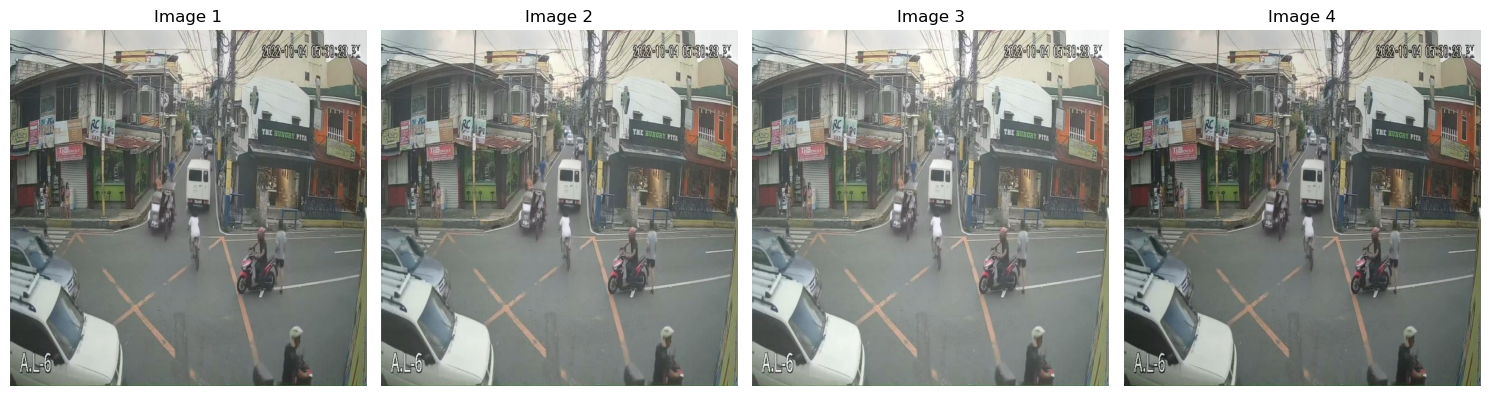

In [6]:
# Check if there are any valid images
if not image_files:
    print("Error: No image files found in the train/images folder. Check if images are in the correct directory.")
else:
    # Select the first four images (or fewer if not enough images are available)
    num_images = min(4, len(image_files))
    sample_images = image_files[:num_images]

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(image_folder, img_name)

        # Load the image
        image = cv2.imread(img_path)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Error: Unable to load image {img_path}. Check if the file exists and is accessible.")
            continue

        # Convert BGR to RGB (since OpenCV loads in BGR format)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image in the subplot
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Image {i+1}")

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

#### **Step 1.5: Load and Display Annotations**

Now that we have loaded and displayed sample images, the next step is to visualize their corresponding annotations. The dataset comes with label files that contain bounding box coordinates for objects in each image. We will parse these labels and overlay the bounding boxes on the images to better understand the dataset structure.

In [7]:
# Define the path to the labels folder
labels_folder = os.path.join(dataset_path, "train", "labels")

# Class names as per your data.yaml file
class_names = {0: 'Full-Faced', 1: 'Half-Faced', 2: 'Invalid', 3: 'Notwearinghelmet', 4: 'Rider'}

print("Labels Folder Path:", labels_folder)
print("\nClass Names:", class_names)

Labels Folder Path: C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset\train\labels

Class Names: {0: 'Full-Faced', 1: 'Half-Faced', 2: 'Invalid', 3: 'Notwearinghelmet', 4: 'Rider'}


In [8]:
# Print first 10 label files
label_files = os.listdir(labels_folder)
print("Label files found:", label_files[:10])  

Label files found: ['5-6-pm_mp4-0000_jpg.rf.05a17379ccccce8dc695ddd36b2eeaa6.txt', '5-6-pm_mp4-0000_jpg.rf.17b621ef978dd999c6d80cca75adac5d.txt', '5-6-pm_mp4-0000_jpg.rf.2ac4bb84e377ffaa3e737eca4c46183f.txt', '5-6-pm_mp4-0000_jpg.rf.64fb6368622abca7e74900ccfc37d2a8.txt', '5-6-pm_mp4-0000_jpg.rf.b032755098139eaca9142f6cd90cc04d.txt', '5-6-pm_mp4-0000_jpg.rf.d63f1c917b1cd39466b56889c2cc64d8.txt', '5-6-pm_mp4-0000_jpg.rf.dc2ed48dcd550b12538c1939bf99d94a.txt', '5-6-pm_mp4-0001_jpg.rf.3d31bd1be5d8183f573047b189aca380.txt', '5-6-pm_mp4-0001_jpg.rf.3eaf38946f379ae5f448c573777ecf91.txt', '5-6-pm_mp4-0001_jpg.rf.4bd623d38489583b49871609ddf6f5ba.txt']


In [9]:
# Access the first label file
label_file_path = os.path.join(labels_folder, label_files[0])  
with open(label_file_path, 'r') as file:
    label_contents = file.readlines()
    print("Contents of the first label file:", label_contents)

Contents of the first label file: ['4 0.79453125 0.90546875 0.0578125 0.1890625\n', '4 0.703125 0.6328125 0.0453125 0.2\n', '1 0.7984375 0.86796875 0.04375 0.0875\n', '0 0.70390625 0.5765625 0.025 0.0578125']


In [10]:
# Check the labels
print("Type of labels:", type(label_files))
print("Length of labels:", len(label_files))

Type of labels: <class 'list'>
Length of labels: 2076


In [11]:
# Function to draw bounding boxes
def draw_bounding_boxes(image, label_path):
    h, w, _ = image.shape  # just to get image dimensions -- dee

    # Read label file
    with open(label_path, "r") as file:
        lines = file.readlines()

    for line in lines:
        data = line.strip().split()
        class_id = int(data[0])  # Class index
        x_center, y_center, box_width, box_height = map(float, data[1:])

        # Convert YOLO format (relative) to pixel coordinates
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = class_names.get(class_id, f"Class {class_id}")
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    return image

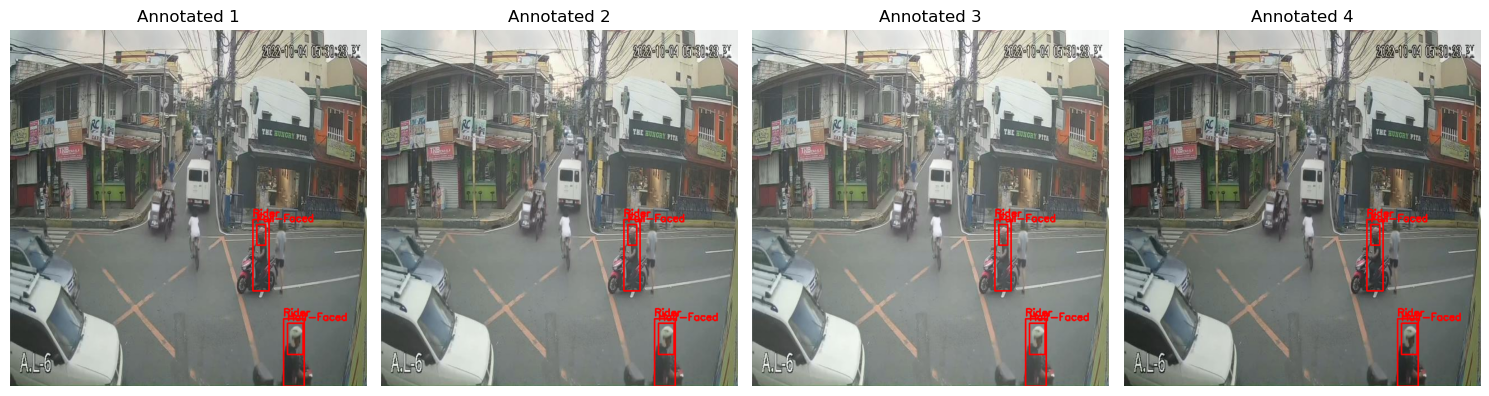

In [12]:
# Display images with bounding boxes
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_name)
    label_path = os.path.join(labels_folder, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    image = cv2.imread(img_path)
    
    if image is None:
        print(f"Error: Unable to load image {img_path}.")
        continue

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes if label file exists
    if os.path.exists(label_path):
        image = draw_bounding_boxes(image, label_path)
    else:
        print(f"Warning: No label file found for {img_name}")

    # Display image
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Annotated {i+1}")

plt.tight_layout()
plt.show()

#### **Step 1.6: Analyze Dataset Distribution**

Before training a model, it's important to analyze the dataset. In this step, we will compute and visualize the distribution of object classes across the dataset. It will help in identifying class imbalances and understanding the dataset composition.

In [13]:
# Initialize a counter for class distribution
class_counts = collections.Counter()

# Read all label files in the test dataset
for label_file in os.listdir(labels_folder):
    label_path = os.path.join(labels_folder, label_file)

    with open(label_path, "r") as file:
        for line in file:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

In [14]:
# Convert counts to class labels
class_labels = [class_names.get(c, f"Class {c}") for c in class_counts.keys()]
class_frequencies = list(class_counts.values())

In [15]:
# Display Class Distribution
for label, frequency in zip(class_labels, class_frequencies):
    print(f"{label}: {frequency}")

Rider: 11075
Half-Faced: 4478
Full-Faced: 4368
Notwearinghelmet: 150
Invalid: 40


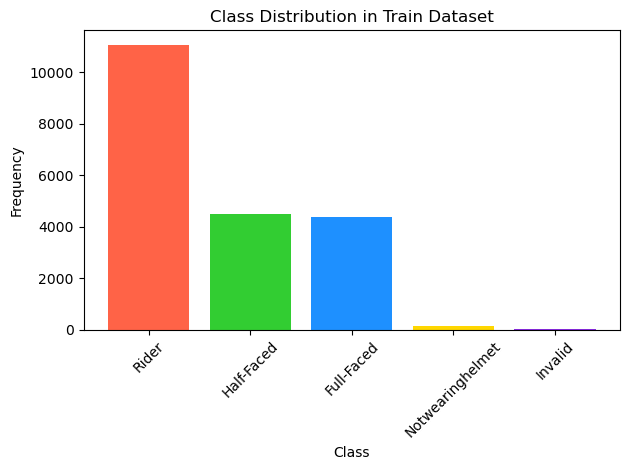

In [16]:
# Assign a different color to each class
colors = ['#FF6347', '#32CD32', '#1E90FF', '#FFD700', '#8A2BE2']

# Create the bar plot using the class names and frequencies already computed
plt.bar(class_labels, class_frequencies, color=colors)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Train Dataset')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## **II. DATA PREPROCESSING**

#### **Step 2.1: Balancing the Dataset Using Class Weights**

To handle class imbalance in the dataset, we calculated class weights using the distribution of labels in the training set. The weights are applied during training to guarantee that the model learns to classify all classes with equal importance while it also prevents the model from being biased toward the majority classes. These weights are computed and used in our deep learning model training. The function below prepares the dataset for balanced training by copying images from the original training directory (train/images) to a new directory (train/balanced_images).

In [17]:
# Function to save balanced images
def save_balanced_images(dataset_path):
    train_folder = os.path.join(dataset_path, 'train', 'images')
    balanced_folder = os.path.join(dataset_path, 'train', 'balanced_images')

    # Create the balanced_images directory if it doesn't exist
    if not os.path.exists(balanced_folder):
        os.makedirs(balanced_folder)

    # Loop over all image files in the train folder
    for img_file in tqdm(os.listdir(train_folder), desc="Saving Balanced Images"):
        img_path = os.path.join(train_folder, img_file)
        
        # Read the image
        image = cv2.imread(img_path)

        # Save the balanced image (without modifications, just saving)
        balanced_img_path = os.path.join(balanced_folder, img_file)
        cv2.imwrite(balanced_img_path, image)

In [18]:
# Define the path to the dataset
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"

# Save the balanced images in a separate folder
save_balanced_images(dataset_path)

Saving Balanced Images: 100%|██████████████████████████████████████████████████████| 2076/2076 [01:43<00:00, 20.13it/s]


#### **Step 2.2: Gamma Correction**

In this step, we apply gamma correction to the balanced images obtained 
from the previous step. Gamma correction is a preprocessing step used to adjust the brightness of images 
by applying a no-nlinear transformation to pixel intensities.Its heled uss improve 
image contra to make theng dark regions more visible without overexposing bright area The function below applies gamma correction to the balanced images and saves the corrected images to a new directory (gamma_corrected_images).  

In [19]:
# Function to apply Gamma Correction to images
def apply_gamma_correction(dataset_path, gamma=1.5):
    train_folder = os.path.join(dataset_path, 'train', 'balanced_images')
    gamma_folder = os.path.join(dataset_path, 'train', 'gamma_corrected_images')

    # Create the gamma_corrected_images directory if it doesn't exist
    if not os.path.exists(gamma_folder):
        os.makedirs(gamma_folder)

    # Prepare the gamma correction lookup table
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")

    # Loop over all images in the balanced folder
    for img_file in tqdm(os.listdir(train_folder), desc="Applying Gamma Correction"):
        img_path = os.path.join(train_folder, img_file)

        # Read the image
        image = cv2.imread(img_path)

        # Apply gamma correction
        gamma_corrected = cv2.LUT(image, table)

        # Save the gamma-corrected image
        gamma_img_path = os.path.join(gamma_folder, img_file)
        cv2.imwrite(gamma_img_path, gamma_corrected)

In [20]:
# Define the path to the dataset
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"

# Apply gamma correction to the balanced images
apply_gamma_correction(dataset_path)

Applying Gamma Correction: 100%|███████████████████████████████████████████████████| 2076/2076 [01:55<00:00, 18.01it/s]


#### **Step 2.3: Image Normalization**

Normalization is considered as a technique to scale the pixel values of images to a standard range which are usually between 0 and 1. We considered this preprocessing step because it helps improve the convergence of training deep learning models by making the gradients more stable during the optimization process. We normalized the images in the train dataset by dividing each pixel value by 255 (the maximum pixel value in an 8-bit image). The function below normalizes the gamma-corrected images by scaling their pixel values to the range [0, 1] and saves them to a new directory (normalized_images).

In [21]:
# Function to normalize the images in the 'train' folder.
def normalize_images(dataset_path, target_size=(224, 224)):
    train_folder = os.path.join(dataset_path, 'train', 'gamma_corrected_images')
    normalized_folder = os.path.join(dataset_path, 'train', 'normalized_images')

    # Create the normalized_images directory if it doesn't exist
    if not os.path.exists(normalized_folder):
        os.makedirs(normalized_folder)

    # Loop over all image files in the train folder
    for img_file in tqdm(os.listdir(train_folder), desc="Normalizing Images"):
        img_path = os.path.join(train_folder, img_file)
        
        # Read the image
        image = cv2.imread(img_path)
        
        # Resize image if needed (to a fixed size, e.g., 224x224)
        image_resized = cv2.resize(image, target_size)
        
        # Normalize the image (divide by 255 to scale to range [0, 1])
        image_normalized = image_resized / 255.0

        # Save the normalized image (8-bit image)
        normalized_img_path = os.path.join(normalized_folder, img_file)
        cv2.imwrite(normalized_img_path, (image_normalized * 255).astype(np.uint8))

In [22]:
# Define the path to the dataset
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"

# Normalize the images in the 'train' folder
normalize_images(dataset_path)

Normalizing Images: 100%|██████████████████████████████████████████████████████████| 2076/2076 [00:53<00:00, 38.85it/s]


#### **Step 2.4: Image Resizing**

The goal of this step is to resize all images in the training dataset to a fixed size (224 x 224). The resizing process made us guarantee consistency before feeding them into the deep learning model. It is important because neural networks generally expect input images to be of the same size. The function below resizes the normalized images to a fixed size and saves them to a new directory (resized_images).

In [23]:
# Function to resize the images in the 'normalized_images' folder to the target size
def resize_images(dataset_path, target_size=(224, 224)):
    normalized_folder = os.path.join(dataset_path, 'train', 'normalized_images')
    resized_folder = os.path.join(dataset_path, 'train', 'resized_images')

    # Create the resized_images directory if it doesn't exist
    if not os.path.exists(resized_folder):
        os.makedirs(resized_folder)

    # Loop over all image files in the normalized_images folder
    for img_file in tqdm(os.listdir(normalized_folder), desc="Resizing Images"):
        img_path = os.path.join(normalized_folder, img_file)
        
        # Read the image
        image = cv2.imread(img_path)
        
        # Resize image to the target size
        image_resized = cv2.resize(image, target_size)

        # Save the resized image
        resized_img_path = os.path.join(resized_folder, img_file)
        cv2.imwrite(resized_img_path, image_resized)

In [24]:
# Define the correct path to the dataset
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"

# Resize the images in the 'normalized_images' folder
resize_images(dataset_path)

Resizing Images: 100%|█████████████████████████████████████████████████████████████| 2076/2076 [00:22<00:00, 91.81it/s]


#### **Step 2.5: Converting Color Spaces (YCrCb and RGB)**

In this step, we converted the images in the dataset to the required color space which will be used for either traditional methods (like CLAHE) or deep learning models. The YCrCb color space is specifically useful for traditional computer vision tasks like CLAHE because it operates on the luminance (Y channel) of the image, whereas RGB is used for deep learning models that generally operate on full color images. The following function converts the resized images to the specified color space (YCrCb or RGB) and saves them to a new directory (color_converted).

In [25]:
# Function to convert images to a specified color space (YCrCb or RGB) and save them
def convert_color_space(dataset_path, target_color_space='YCrCb'):
    resized_folder = os.path.join(dataset_path, 'train', 'resized_images')
    color_converted_folder = os.path.join(dataset_path, 'train', 'color_converted')

    # Create the color_converted folder if it doesn't exist
    if not os.path.exists(color_converted_folder):
        os.makedirs(color_converted_folder)

    # Loop over all resized image files
    for img_file in tqdm(os.listdir(resized_folder), desc="Converting Color Spaces"):
        img_path = os.path.join(resized_folder, img_file)
        
        # Read the image
        image = cv2.imread(img_path)
        
        # Convert the image color space
        if target_color_space == 'YCrCb':
            image_converted = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)  
            image_saved = cv2.cvtColor(image_converted, cv2.COLOR_YCrCb2BGR)
            image_converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image_saved = image_converted
        else:
            raise ValueError("Unsupported color space. Use 'YCrCb' or 'RGB'.")

        # Save the converted image
        converted_img_path = os.path.join(color_converted_folder, img_file)
        cv2.imwrite(converted_img_path, image_saved)

In [26]:
# Define the correct path to the dataset
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"

# Convert the resized images to YCrCb for CLAHE or leave as RGB for deep learning
convert_color_space(dataset_path, target_color_space='YCrCb')

Converting Color Spaces: 100%|████████████████████████████████████████████████████| 2076/2076 [00:20<00:00, 103.62it/s]


## **III. MODELING PHASE**

#### **Step 3.1:  Traditional Model**

For our traditional algorithm, we applied a traditional image enhancement technique known as the CLAHE (Contrast Limited Adaptive Histogram Equalization) to the 5-6 PM video scene images. Our objective is to improve the visibility and contrast of the low-light images by modifying the luminance channel (Y-channel) in the YCrCb color space. CLAHE operates in terms of improving the image contrast locally which is ideal for improving image details in regions with poor lighting. This function below applies CLAHE to the images in the 5-6 PM video scene folder to improve visibility and contrast.

In [27]:
# Apply CLAHE
def apply_clahe_to_video_scene(dataset_path, video_scene_folder, output_folder, clip_limit=2.0, tile_grid_size=(8,8), gamma=1.1, alpha=0.8):
    video_scene_images_folder = os.path.join(dataset_path, video_scene_folder)
    output_scene_folder = os.path.join(dataset_path, output_folder)

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_scene_folder):
        os.makedirs(output_scene_folder)

    # Loop through all images in the video scene folder
    for img_file in tqdm(os.listdir(video_scene_images_folder), desc=f"Processing {video_scene_folder}"):
        img_path = os.path.join(video_scene_images_folder, img_file)

        # Read the image
        image = cv2.imread(img_path)

        # Convert to YCrCb color space
        ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

        # Split the channels
        y, cr, cb = cv2.split(ycrcb_image)

        # Apply CLAHE to the Y channel (luminance)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        y_clahe = clahe.apply(y)

        # Merge the channels back together
        ycrcb_clahe_image = cv2.merge([y_clahe, cr, cb])

        # Convert back to BGR
        clahe_bgr_image = cv2.cvtColor(ycrcb_clahe_image, cv2.COLOR_YCrCb2BGR)

        # Apply gamma correction
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
        gamma_corrected = cv2.LUT(clahe_bgr_image, table)

        # Blend CLAHE output with the original to retain details
        final_image = cv2.addWeighted(gamma_corrected, alpha, image, (1 - alpha), 0)

        # Values are within valid range
        final_image = np.clip(final_image, 0, 255).astype(np.uint8)

        # Save the enhanced image
        output_img_path = os.path.join(output_scene_folder, img_file)
        cv2.imwrite(output_img_path, final_image)

    print(f"Processing complete. Enhanced images saved to: {output_scene_folder}")

In [28]:
# Define the paths for the 5-6 PM dataset and output folder
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset"
video_scene_folder = 'train/color_converted'
output_folder = 'train/clahe_processed_5_6pm'

# Apply CLAHE to the 5-6 PM video scene
apply_clahe_to_video_scene(dataset_path, video_scene_folder, output_folder)

Processing train/color_converted: 100%|████████████████████████████████████████████| 2076/2076 [00:30<00:00, 68.67it/s]

Processing complete. Enhanced images saved to: C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset\train/clahe_processed_5_6pm


#### **Step 3.2: Deep Learning Model - Zero-DCE (Zero-Reference Deep Curve Estimation)**

For our deep learning model, we used the Zero-DCE (Zero-Reference Deep Curve Estimation) model to the 5-6 PM video scene images. Unlike CLAHE, which is a traditional image enhancement technique, Zero-DCE is a deep learning-based method that enhances images by learning the proper enhancement curves from low-light images without requiring a reference (ground truth) image. It performs image enhancement in an unsupervised manner which also makes it ideal for real-world scenarios where paired training data might not be available.

In [29]:
# Apply Zero-DCE model with improvements
def apply_zero_dce_to_video_scene(dataset_path, output_folder, batch_size=50, gamma=1.5, blend_ratio=0.7):
    # Makes sure that the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Load the Zero-DCE model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = enhance_net_nopool().to(device)  
    model.eval()

    # Load the dataset (ensure lowlight_loader returns image tensors + paths)
    dataset = lowlight_loader(os.path.join(dataset_path, 'resized_images'))

    # Define transformation (keep values in [0,1] range)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Process images in batches
    for batch_start in tqdm(range(0, len(dataset), batch_size), desc="Processing", unit="batch"):
        batch_end = min(batch_start + batch_size, len(dataset))

        for i in range(batch_start, batch_end):
            image_tensor, image_path = dataset[i]  # returns (tensor, path)

            # Load original image for blending
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

            # Prepare image for model
            image = image_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                enhanced_image, _, _ = model(image)

            # Convert back to image format
            enhanced_image = enhanced_image.squeeze().cpu().numpy()
            enhanced_image = np.transpose(enhanced_image, (1, 2, 0))  # convert CHW → HWC

            # Pixel values are correctly scaled
            enhanced_image = np.clip(enhanced_image * 255.0, 0, 255).astype(np.uint8)

            # Apply gamma correction
            inv_gamma = 1.0 / gamma
            table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
            gamma_corrected = cv2.LUT(enhanced_image, table)

            # Blend with original image to retain details
            final_image = cv2.addWeighted(gamma_corrected, blend_ratio, original_image, (1 - blend_ratio), 0)

            # Save output using original filename
            output_image_path = os.path.join(output_folder, f"{Path(image_path).stem}_enhanced.jpg")
            cv2.imwrite(output_image_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

    print("Processing complete.")

In [30]:
# Define the paths for the 5-6 PM dataset and output folder
dataset_path = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset\train"
output_folder = r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset\train\zero_dce_processed_5_6pm"

# Apply Zero-DCE to the 5-6 PM video scene
apply_zero_dce_to_video_scene(dataset_path, output_folder)

Processing: 100%|███████████████████████████████████████████████████████████████████| 42/42 [06:38<00:00,  9.48s/batch]

Processing complete.


## **IV. RESULTS**

The evaluation of the image enhancement techniques (CLAHE and Zero-DCE) was conducted using multiple metrics in order for us to assess their performance in detail. These metrics include (1) visual comparison, (2) luminance analysis, (3) background clarity, (4) contrast improvement, and (5) object detection accuracy. Each metric provided unique insights into the effectiveness of the enhancement methods so we can compare the traditional (CLAHE) and deep learning-based (Zero-DCE) approaches. We explained the codes used for each evaluation step before a discussion of the results obtained.

#### **Step 4.1: Visual Comparison**

And then for the results, we first did a visual comparison to evaluate the effectiveness of the CLAHE and Zero-DCE enhancement methods by comparing the original, CLAHE-enhanced, and Zero-DCE-enhanced images. It provided a qualitative assessment of the enhancement techniques like improvements in visibility, contrast, and overall image quality. The code loads the original, CLAHE, and Zero-DCE images for proper filename matching and displays them side by side for comparison. 

In [31]:
# Define folder paths
folder_path_org = Path(r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset\train\images")
folder_path_clahe = Path(r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset\train\clahe_processed_5_6pm")
folder_path_dce = Path(r"C:\Users\Daniella Kim N. Nilo\OneDrive\Desktop\Nilo_PythonFiles\Nilo_DataScience3\Nilo_M2-Summative\5-6pm_dataset\train\zero_dce_processed_5_6pm")

# Get list of image files in the original folder (filter for images)
image_files = [f for f in os.listdir(folder_path_org) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

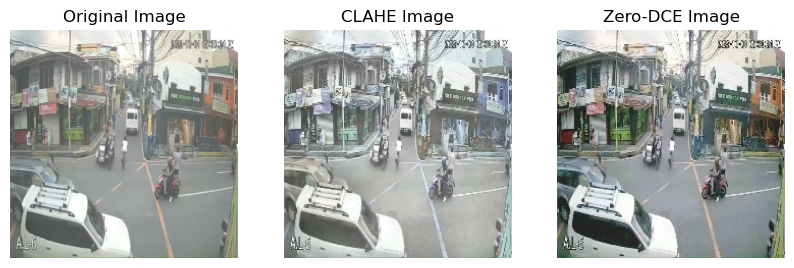

In [32]:
# Check if there are any images
if not image_files:
    print("No images found in the original folder!")
else:
    # Select the first image
    image_filename = image_files[16]
    original_path = folder_path_org / image_filename
    clahe_path = folder_path_clahe / image_filename

    # Fix Zero-DCE filename matching
    zero_dce_filename = image_filename.replace('.jpg', '_enhanced.jpg')
    zero_dce_path = folder_path_dce / zero_dce_filename

    # Load images safely
    def load_image(img_path):
        if img_path.exists():
            return cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        return None

    original = load_image(original_path)
    clahe = load_image(clahe_path)
    zero_dce = load_image(zero_dce_path)

    # Display images (fallback to placeholders if any are missing)
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    titles = ['Original Image', 'CLAHE Image', 'Zero-DCE Image']
    images = [original, clahe, zero_dce]

    for ax, img, title in zip(axes, images, titles):
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, 'Image Not Found', fontsize=12, ha='center', va='center', color='red')
            ax.set_facecolor('gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

#### **Step 4.2:  Luminance Comparison**

In this step, we evaluated the luminance (brightness) of the original, CLAHE-enhanced, and Zero-DCE-enhanced images. Luminance is an important measure of perceived brightness because it directly impacts the visual quality of an image. The code calculates the average luminance for each image by converting it to grayscale and computing the mean pixel intensity. It also computes the percentage change in luminance for the enhanced images relative to the original and between the two enhancement methods. It will help us understand how CLAHE and Zero-DCE affect the brightness of the images.

In [33]:
# Function to calculate luminance (brightness)
def calculate_luminance(image):
    # image must be in RGB format before conversion
    if image is None:
        return None
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
    # compute average luminance
    return np.mean(gray) 

# Calculate luminance for each image
luminance_original = calculate_luminance(original)
luminance_clahe = calculate_luminance(clahe)
luminance_zero_dce = calculate_luminance(zero_dce)

In [34]:
# Validate computations
if None not in [luminance_original, luminance_clahe, luminance_zero_dce]:
    # Compute percentage changes
    luminance_change_clahe = ((luminance_clahe - luminance_original) / luminance_original) * 100
    luminance_change_zero_dce = ((luminance_zero_dce - luminance_original) / luminance_original) * 100
    luminance_change_clahe_vs_zero_dce = ((luminance_zero_dce - luminance_clahe) / luminance_clahe) * 100

    # Print results
    print(f"Luminance (Original): {luminance_original:.2f}")
    print(f"Luminance (CLAHE): {luminance_clahe:.2f} ({luminance_change_clahe:.2f}% change)")
    print(f"Luminance (Zero-DCE): {luminance_zero_dce:.2f} ({luminance_change_zero_dce:.2f}% change)")
    print(f"Luminance Change (CLAHE → Zero-DCE): {luminance_change_clahe_vs_zero_dce:.2f}%")
else:
    print("Error: One or more images could not be processed.")

Luminance (Original): 153.19
Luminance (CLAHE): 168.42 (9.94% change)
Luminance (Zero-DCE): 145.38 (-5.09% change)
Luminance Change (CLAHE → Zero-DCE): -13.68%


#### **Step 4.3:  Background Calculation**

For our background calculation, we analyzed the background intensity of the original, CLAHE-enhanced, and Zero-DCE-enhanced images. Background intensity is a very important factor in evaluating image quality since it affects the contrast and clarity of objects in the foreground. The code isolates the background using Otsu’s thresholding in order to separates the foreground and background based on pixel intensity. The average intensity of the background pixels is calculated before we computed for the percentage change in intensity relative to the original image.

In [35]:
def calculate_background_intensity(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's thresholding to separate foreground and background
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Extract background pixels (where thresholded image is white)
    background_pixels = gray[thresholded == 255]
    
    # Compute average intensity of the background
    if len(background_pixels) > 0:
        return background_pixels.mean()
    return 0

In [36]:
# Compute background intensity for each image
background_original = calculate_background_intensity(original)
background_clahe = calculate_background_intensity(clahe)
background_zero_dce = calculate_background_intensity(zero_dce)

# Compute percentage changes relative to the original
background_change_clahe = ((background_clahe - background_original) / background_original) * 100
background_change_zero_dce = ((background_zero_dce - background_original) / background_original) * 100
background_change_clahe_vs_zero_dce = ((background_zero_dce - background_clahe) / background_clahe) * 100

In [37]:
# Print results
print(f"Background Intensity (Original): {background_original:.2f}")
print(f"Background Intensity (CLAHE): {background_clahe:.2f} ({background_change_clahe:.2f}% change)")
print(f"Background Intensity (Zero-DCE): {background_zero_dce:.2f} ({background_change_zero_dce:.2f}% change)")
print(f"Background Change (CLAHE → Zero-DCE): {background_change_clahe_vs_zero_dce:.2f}%")

Background Intensity (Original): 217.47
Background Intensity (CLAHE): 199.81 (-8.12% change)
Background Intensity (Zero-DCE): 181.10 (-16.72% change)
Background Change (CLAHE → Zero-DCE): -9.36%


#### **Step 4.4:  Contrast Comparison**

In this step, we assessed the contrast of the original, CLAHE-enhanced, and Zero-DCE-enhanced images using Root Mean Square (RMS) Contrast. RMS contrast is a good measure that quantifies the overall intensity variation in an image and it provides numerical results about how enhancement techniques improve both local and global contrast. The code calculates the RMS contrast for each image and computes the percentage change in contrast relative to the original image and between the two enhancement methods.

In [38]:
# Function to compute RMS Contrast
def compute_rms_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_intensity = np.mean(gray)
    rms_contrast = np.sqrt(np.mean((gray - mean_intensity) ** 2))
    return rms_contrast

In [39]:
# Compute contrast for each image
contrast_original = compute_rms_contrast(original)
contrast_clahe = compute_rms_contrast(clahe)
contrast_zero_dce = compute_rms_contrast(zero_dce)

# Compute percentage change
contrast_change_clahe = ((contrast_clahe - contrast_original) / contrast_original) * 100
contrast_change_zero_dce = ((contrast_zero_dce - contrast_original) / contrast_original) * 100
contrast_change_clahe_vs_zero_dce = ((contrast_zero_dce - contrast_clahe) / contrast_clahe) * 100

In [40]:
# Print results
print(f"Contrast (Original): {contrast_original:.2f}")
print(f"Contrast (CLAHE): {contrast_clahe:.2f} ({contrast_change_clahe:.2f}% change)")
print(f"Contrast (Zero-DCE): {contrast_zero_dce:.2f} ({contrast_change_zero_dce:.2f}% change)")
print(f"Contrast Change (CLAHE → Zero-DCE): {contrast_change_clahe_vs_zero_dce:.2f}%")

Contrast (Original): 46.06
Contrast (CLAHE): 46.46 (0.86% change)
Contrast (Zero-DCE): 57.66 (25.18% change)
Contrast Change (CLAHE → Zero-DCE): 24.11%


#### **Step 4.5:  Detected Objects (Object Detection)**

Finally, we observed the performance of object detection on the original, CLAHE-enhanced, and Zero-DCE-enhanced images. Object detection is very important in the domain of Computer Vision to understand how well the enhancement methods preserve or improve the visibility of objects in the images. The code uses contour detection to identify objects by converting the images to grayscale before applying Gaussian blur to reduce noise and using Canny edge detection to find edges. After that, the number of detected contours is then counted and compared across the images.

In [41]:
# Function to detect objects using contour detection
def count_objects(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

In [42]:
# Count objects in each image
objects_original = count_objects(original)
objects_clahe = count_objects(clahe)
objects_zero_dce = count_objects(zero_dce)

# Compute percentage change
objects_change_clahe = ((objects_clahe - objects_original) / objects_original) * 100
objects_change_zero_dce = ((objects_zero_dce - objects_original) / objects_original) * 100
objects_change_clahe_vs_zero_dce = ((objects_zero_dce - objects_clahe) / objects_clahe) * 100

In [43]:
# Print results
print(f"Detected Objects (Original): {objects_original}")
print(f"Detected Objects (CLAHE): {objects_clahe} ({objects_change_clahe:.2f}% change)")
print(f"Detected Objects (Zero-DCE): {objects_zero_dce} ({objects_change_zero_dce:.2f}% change)")
print(f"Objects Change (CLAHE → Zero-DCE): {objects_change_clahe_vs_zero_dce:.2f}%")

Detected Objects (Original): 382
Detected Objects (CLAHE): 111 (-70.94% change)
Detected Objects (Zero-DCE): 116 (-69.63% change)
Objects Change (CLAHE → Zero-DCE): 4.50%


## **V. DISCUSSION**

### **5.1 Visual Comparison**

The visual comparison for the 5-6PM dataset showed the differences between the original image and its enhanced versions using CLAHE and Zero-DCE. The original image served as our baseline and it had issues like low brightness, poor contrast, or noise in low-light conditions. These limitations make it difficult to discern fine details or objects in darker regions. The CLAHE-enhanced image showed notable improvements in visibility in darker areas because of its ability to enhance local contrast. Details that were previously covered in shadows became a bit clearer and the overall contrast is heightened. However, the enhancement can sometimes lead to over-processing which can result in unnatural-looking regions or artifacts in areas with immediate brightness changes.

On the other hand, the Zero-DCE-enhanced image provided a more balanced improvement. It effectively brightens the image to improve its visibility in low-light areas without introducing too much noise or artifacts. The contrast is improved in a natural way to preserve the original tonal balance and avoiding over-enhancement. The result is also a more visually pleasing image that maintains a natural appearance with fewer artifacts and better preservation of color tones. Therefore, Zero-DCE striked a good balance between the improvement of details and retention of the image's original characteristics.

### **5.2 Luminance Comparison**

The luminance comparison for the 5-6PM dataset proved how the CLAHE and Zero-DCE enhancement methods affect the brightness of the images. The original image has an average luminance of 153.19 as the baseline for comparison. The CLAHE-enhanced image shows a significant increase in luminance with a value of 168.42 and it means that there's a 9.94% increase relative to the original. The increase aligns with CLAHE's ability to improve local contrast and brightness in darker regions which makes the image appear more vivid and detailed. 

In comparison, the Zero-DCE-enhanced image has a luminance of 145.38 which is 5.09% lower than the original. The reduction in luminance means that Zero-DCE prioritizes balancing brightness and preserving natural appearance over simply increasing overall brightness. Even though the luminance is slightly lower, the image maintains a more natural look and it avoids the over-enhancement or artifacts that can occur with methods like CLAHE.

If we compare both enhancement methods based on luminosity, the luminance of the Zero-DCE image is 13.68% lower than that of the CLAHE image.

### **5.3 Background Calculation Comparison**

The background intensity analysis for the 5-6PM dataset also provided results into how the CLAHE and Zero-DCE enhancement methods affect the background of the images. The original image has a background intensity of 217.47 as the baseline for comparison. The CLAHE-enhanced image shows a background intensity of 199.81 which means that there's an 8.12% decrease relative to the original. The reduction shows that CLAHE tends to darken the background in order to improve the contrast between the foreground and background so the objects in the foreground stand out more clearly. 

As for the deep learning enhancement, the Zero-DCE-enhanced image has a background intensity of 181.10 and it is 16.72% lower than the original. The significant reduction means that Zero-DCE further darkens the background compared to CLAHE. Despite the enhancement it provides for the contrast between the foreground and background, it may also result in a loss of detail in darker regions of the background.

If we compare both enhancement methods based on background metric calculations, the background intensity of the Zero-DCE image is 9.36% lower than that of the CLAHE image.

### **5.4 Contrast Comparison**

The contrast comparison for the 5-6PM dataset through the use of Root Mean Square (RMS) contrast showed notable differences between the original and enhanced images. The original image has an RMS contrast of 46.06 that served as our baseline for comparison. The CLAHE-enhanced image shows a slight increase in contrast with a value of 46.46 so it means that there's a 0.86% increase relative to the original. The slight improvement proves that CLAHE can improve local contrast in regions that are relatively darker but its impact on overall contrast is just limited.

On the other hand, the Zero-DCE-enhanced image displays a substantial increase in contrast because it has a RMS contrast of 57.66 which means a 25.18% increase relative to the original. This significant improvement shows Zero-DCE’s ability to enhance both local and global contrast to make the image appear more realistic. The higher contrast in the Zero-DCE image is consistent with its ability to balance brightness and preserve natural appearance while enhancing details.

If we compare both enhancement methods according to contrast, the contrast of the Zero-DCE image is 24.11% higher than that of the CLAHE image.

### **5.5 Object Detection Performance Comparison**

In terms of Object Detection performance for the 5-6PM dataset, the results showed significant differences in the  number of detected objects across the original and enhanced images. The original image has 382 detected objects as the baseline for comparison. The CLAHE-enhanced image shows a substantial reduction in detected objects with only 111 objects detected which means that there's a 70.94% decrease relative to the original. The reduction further proves that CLAHE’s enhancement process may merge or obscure edges and it may lead to fewer detected contours.

The results are almost the same with the Zero-DCE-enhanced image because the results also reveal that it only detected 116 objects which represents a 69.63% decrease relative to the original. Even though the calculation result is slightly better than CLAHE, the reduction is still considered significant since it indicates that Zero-DCE also affects edge detection, despite the number being to a lesser extent.

When comparing both enhancement methods directly, the number of detected objects in the Zero-DCE image is 4.50% higher than in the CLAHE image. 

## **VI. CONCLUSION**

Based on the discussion of our metric results for the 5-6PM dataset of the CLAHE and Zero-DCE enhancement methods have their own advantages and limitations. The visual comparison proved that CLAHE can improve local contrast and visibility in darker regions but may introduce artifacts and over-enhancement. On the other hand, Zero-DCE offers a more balanced enhancement to improve visibility and contrast while maintaining a natural appearance with fewer artifacts.

The luminance comparison also showed that CLAHE increases brightness by 9.94% while Zero-DCE reduces it by 5.09% which mean that CLAHE tends to amplify brightness compared to Zero-DCE that prioritizes a natural look. The background intensity analysis further proved that both methods darken the background with Zero-DCE having a more pronounced effect (16.72% reduction compared to CLAHE’s 8.12% reduction). The darkening might improve foreground-background contrast but may result in a loss of detail in darker regions. 

The contrast comparison through the use of Root Mean Square (RMS) contrast confirmed that Zero-DCE outperforms CLAHE with a 25.18% increase in contrast compared to CLAHE’s modest 0.86% increase. It means that Zero-DCE is more effective in improving both local and global contrast which can contribute to a more realistic and detailed image. However, the object detection performance revealed a trade-off. Both methods reduced the number of detected objects significantly because CLAHE demonstrated a 70.94% reduction while Zero-DCE resulted in a 69.63% reduction. The observation indicates that while both methods enhance image quality, they may merge or obscure edges which can affect the ability to detect fine details and objects.

Therefore, Zero-DCE emerges as the more balanced and effective enhancement method because it has significant improvements in contrast and maintaining a natural appearance while slightly outperforming CLAHE when it comes to edge preservation. Unfortunately, both methods have limitations in preserving the fine details necessary for object detection. We recommend that future research can center on optimizing these techniques to better preserve edges and fine details while also being able to maintain their enhancement capabilities.

## **VII. REFERENCES**

1. Siril. (n.d.). CLAHE (Contrast Limited Adaptive Histogram Equalization). Retrieved from https://siril.readthedocs.io/en/latest/processing/clahe.html

2. OpenCV. (n.d.). cv::CLAHE Class Reference. Retrieved from https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html

3. Guo, C., Li, C., Guo, J., Loy, C. C., Hou, J., Kwong, S., & Cong, R. (2020). Zero-reference deep curve estimation for low-light image enhancement. *In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)*, 1780-1789. https://li-chongyi.github.io/Proj_Zero-DCE.html
   
4. Li, C., Guo, C., & Loy, C. C. (2024). Zero-DCE: Zero-reference deep curve estimation for low-light image enhancement [Computer software]. Retrieved from https://github.com/Li-Chongyi/Zero-DCE.git